<a href="https://colab.research.google.com/github/Himagination/DeepLearning_Projects/blob/main/Tumour_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

fatal: destination path 'Brain-Tumor-Classification-DataSet' already exists and is not an empty directory.


In [3]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [4]:
data_dir ="/content/Brain-Tumor-Classification-DataSet"
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/Training")
print(classes)

['Testing', 'Training', '.git']
['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']


In [5]:
for tumor in classes:
  train_files = os.listdir(data_dir + "/Training/" + tumor)
  print(f"No. of {tumor} files: {len(train_files)}")

No. of glioma_tumor files: 826
No. of meningioma_tumor files: 822
No. of pituitary_tumor files: 827
No. of no_tumor files: 395


In [6]:
train_transform = transforms.Compose([transforms.Resize([256, 256]), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(), 
                                ])
valid_transform = transforms.Compose([transforms.ToTensor()])

In [7]:
train_ds = ImageFolder(data_dir + "/Training", train_transform)                                            
valid_ds = ImageFolder(data_dir + "/Testing", valid_transform)                                          

In [8]:
img, label = train_ds[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [9]:
print(train_ds.classes)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [10]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams["figure.facecolor"] = "#ffffff"

In [11]:
def show_sample(img, label):
  print(f"Label: {train_ds.classes[label]}, ({str(label)})")
  plt.imshow(img.permute(1, 2, 0)) # Matplotlib accepts (H, W, C)

Label: glioma_tumor, (0)


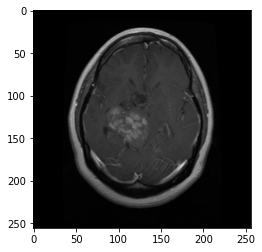

In [12]:
show_sample(*train_ds[0])

Label: meningioma_tumor, (1)


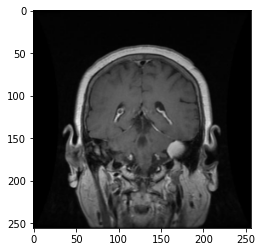

In [13]:
show_sample(*train_ds[1000])

In [14]:
random_seed = 31415926
torch.manual_seed(random_seed);

In [15]:
train_dl = DataLoader(train_ds, 
                      batch_size=8, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)
val_dl = DataLoader(valid_ds, 
                    batch_size=8, 
                    num_workers=4, 
                    pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

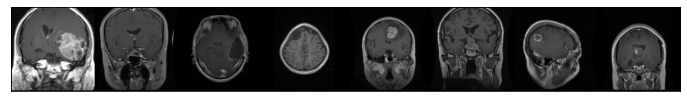

In [17]:
show_batch(train_dl)

## Using GPU

In [18]:
def get_default_device():
  """select GPU if available"""
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")

def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device= device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [21]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = nn.functional.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = nn.functional.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), "val_acc": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {"val_loss": epoch_loss.item(), 
            "val_acc": epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print(f"Epoch [{epoch}], train_loss: {result['train_loss']}, val_loss: {result['val_loss']}, val_acc: {result['val_acc']}")



In [23]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, 
                      out_channels, 
                      kernel_size=3, 
                      padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(4))
  return nn.Sequential(*layers)

In [32]:
class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    # Input_size = (8, 3, 256, 256) (batch_size, n_channels, Height, Width)
    self.conv1 = conv_block(in_channels, 64)
    # Output_size = (8, 64, 256, 256)
    self.conv2 = conv_block(64, 128, pool=True)
    # Output_size = (8, 128, 64, 64)
    self.res1 = nn.Sequential(conv_block(128, 128), 
                              conv_block(128, 128))
    # Output_size = (8, 128, 64, 64)    
    self.conv3 = conv_block(128, 256, pool=True)
    # Output_size = (8, 256, 16, 16)
    self.conv4 = conv_block(256, 512, pool=True)
    # Output_size = (8, 512, 4, 4)
    self.res2 = nn.Sequential(conv_block(512, 512), 
                              conv_block(512, 512))
    # Output_size = (8, 512, 4, 4)    
    self.classifier = nn.Sequential(nn.MaxPool2d(4), # Output size = (8, 512, 1, 1)
                                    nn.Flatten(), # Output_size = (8, 512)
                                    nn.Dropout(0.2), 
                                    nn.Linear(512, num_classes))
    
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    # Make Residual Connection
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    # Make Residual Connection
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [33]:
model = to_device(ResNet9(3, len(train_ds.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group["lr"]

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
  # Clean up GPU 
  torch.cuda.empty_cache()
  history = []
  # Custom Optimizer with weight_decay
  optimizer = opt_func(model.parameters(), 
                       max_lr, 
                       weight_decay=weight_decay)
  # Set up one-cycle learning rate scheduler
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                  max_lr, 
                                                  epochs=epochs, 
                                                  steps_per_epoch=len(train_loader))
  for epoch in range(epochs):
    # Training
    model.train()
    train_losses = []
    lr_vals = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      # Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()
      # Update Learning Rate
      lr_vals.append(get_lr(optimizer))
      scheduler.step()
    # Validation
    result = evaluate(model, val_loader)
    result["train_loss"] = torch.stack(train_losses).mean().item()
    result["lr_vals"] = lr_vals
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [35]:
history = [evaluate(model, val_dl)]
history

RuntimeError: ignored

In [27]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [31]:
history = fit_one_cycle(epochs, 
                        max_lr, 

TypeError: ignored

In [32]:
def plot_accuracies(history):
  accuracies = [x["val_acc"] for x in history]
  plt.plot(accuracies, "-x")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs. no. of epochs")

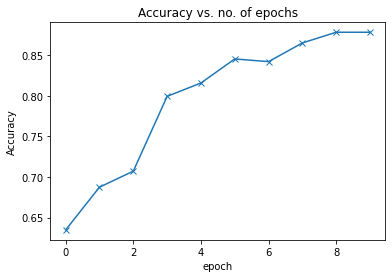

In [33]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
  train_losses = [x.get("train_loss") for x in history]
  val_losses = [x["val_loss"] for x in history]
  plt.plot(train_losses, "-bx")
  plt.plot(val_losses, "-rx")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend(["Training", "Validation"])
  plt.title("Loss vs. No. of Epochs");

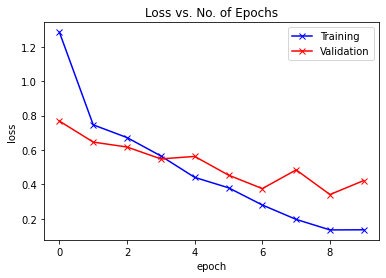

In [36]:
plot_losses(history)

In [37]:
test_dataset = torchvision.datasets.ImageFolder(data_dir + "/Testing", 
                                           transform=transform)

In [38]:
def predict_image(img, model):
  # Convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  # Get prediction from model
  yb = model(xb)
  # Pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  # Retrieve the class Label
  return dataset.classes[preds[0].item()]


Label: meningioma_tumor, Predicted: no_tumor


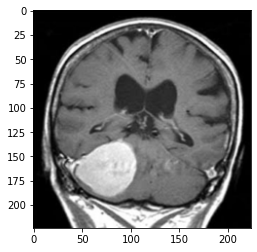

In [43]:
img, label = test_dataset[120]
plt.imshow(img.permute(1, 2, 0))
print(f"Label: {dataset.classes[label]}, Predicted: {predict_image(img, model)}")

In [44]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=8), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.675000011920929, 'val_loss': 5.024722576141357}